<br><font face="Times New Roman" size=5><div dir=ltr align=center>
<font color=blue size=8>
    Introduction to Machine Learning <br>
<font color=red size=5>
    Sharif University of Technology - Computer Engineering Department <br>
    Fall 2022<br> <br>
<font color=black size=6>
    Homework 2: Practical - Linear Regression
    </div>
<br><br>
<font size=4>
   **Name**: <br>
   **Student ID**: <br> <br>

<font face="Times New Roman" size=4><div dir=ltr>
# Problem 1: Linear Regression Model (40 + 30 optional points)
According to <a href="https://github.com/asharifiz/Introduction_to_Machine_Learning/blob/main/Jupyter_Notebooks/Chapter_02_Classical_Models/Linear%20regression.ipynb"><font face="Roboto">Linear Regression Notebook</font></a>, train a linear regression model on an arbitrary dataset. Explain your chosen dataset and split your data into train and test sets, then predict values for the test set using your trained model. Try to find the best hyperparameters for your model. (Using Lasso Regression, Ridge Regression or Elastic Net and comparing them will have extra optional points)
<br> Explain each step of your workflow.

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [40]:
"""
Description of dataset
I downloaded ths dataset from here:
https://www.kaggle.com/datasets/tanyachawla412/house-prices
This dataset contains 7 coulumns which are as follows;
    Avg. Area Income: average income of neighbors in the area that house located,
    House Age: age of house in years,
    Number of Rooms,
    Number of Bedrooms,
    Area Population,
    Price,
    Address;
but I removed the address column because it was unnecessary. So finally we have
5 features and 1 target and also, totally we have 4548 data points in the file.
"""

class DataPreparaton():

    """
    Data set is supposed to be a .csv file and its header (first row)
    has a form like below:

    feature_1    feature_2    ...    feature_n    target

    Args:
        data_csv_path: full path of the .csv file which includes all data.
        normalize [str]: if not false then features data will be normalized using
                   one of these options: 'linear', 'z_score'.
        test_size [int]: to determine what fraction of all data should be used 
                   as test data when splitting the data into test and train data.
        saving [bool]: if true then all usefull returning files will be saved in directory.

    Returns:

    """
    def __init__(self, data_csv_path, normalization_state='linear', test_size=0.2, saving=True,
                 random_state=42, saving_directory='', normalized_file_name='normalized',
                 train_file_name='train_data', test_file_name='test_data'):
        self.data_csv_path = data_csv_path
        self.normalization_state = normalization_state
        self.test_size = test_size
        self.saving = saving
        self.random_state = random_state
        self.saving_directory = saving_directory
        self.normalized_file_name = normalized_file_name
        self.train_file_name = train_file_name
        self.test_file_name = test_file_name
        self.feature_names = None
        self.target_name = None
        self.data_shape = None
        self.train_shape = None
        self.test_shape = None
        self.find_feature_target_names()
        self.is_normalized_data_made = None
        
    def find_feature_target_names(self):

        if self.feature_names==None:
            with open (self.data_csv_path, 'r') as file:
                header = file.readline() 
            header = np.array([name for name in header.split(',')])
            self.feature_names = header[0:-1]
            self.target_name = header[-1]

    def normalize_feature_data(self):
        
        data = np.loadtxt(self.data_csv_path, delimiter=',', skiprows=1)
        data_num = data.shape[0]
        features_target_num = data.shape[1]
        indices = [i for i in range(features_target_num-1)]
        normalized_data = np.zeros((data_num, features_target_num))
        if self.normalization_state=='linear':
            min_s = np.tile(np.min(data[0:, indices], axis=0), (data_num, 1))
            max_s = np.tile(np.max(data[0:, indices], axis=0), (data_num, 1))
            normalized_data[0:, indices] = (data[0:, indices]-min_s) / (max_s-min_s)
            normalized_data[0:, features_target_num-1] = data[0:, features_target_num-1]

        elif self.normalization_state=='z_score':
            mean_s = np.tile(np.mean(data[0:, indices], axis=0), (data_num, 1))
            var_s = np.tile(np.var(data[0:, indices], axis=0), (data_num, 1))
            normalized_data[0:, indices] = (data[0:, indices] - mean_s) / var_s
            normalized_data[0:, features_target_num-1] = data[0:, features_target_num-1]

        if self.saving:
            np.savetxt(self.saving_directory+self.normalized_file_name+'.csv', normalized_data, delimiter=',')
        if self.is_normalized_data_made==None:
            self.is_normalized_data_made = True
        return normalized_data

    def split_data(self, using_normalized_data=False):
        np.random.seed(self.random_state)
        if using_normalized_data:
            if self.is_normalized_data_made==None:
                self.normalize_feature_data()
            data = np.loadtxt(self.saving_directory+self.normalized_file_name+'.csv', delimiter=',')
        else:
            data = np.loadtxt(self.data_csv_path, delimiter=',', skiprows=1)
        data_num = data.shape[0]
        self.data_shape = data.shape
        print('data_num:', data_num)
        test_size = int(data_num*self.test_size)

        test_indices = np.random.choice(test_size, test_size, replace=False)
        train_indices = []

        for index in range(data_num):
            if index not in test_indices:
                train_indices.append(index)

        test_data = data[test_indices, :]
        train_data = data[train_indices, :]
        self.test_shape = test_data.shape
        self.train_shape = train_data.shape
        if len(test_data)+len(train_data)==data_num:
            if self.saving:
                np.savetxt(self.saving_directory+self.train_file_name+'.csv', train_data, delimiter=',')
                np.savetxt(self.saving_directory+self.test_file_name+'.csv', test_data, delimiter=',')  
            return train_data, test_data
    
    def summary(self):
        print(f"""
        Data Shape: {self.data_shape}
        Train Data Shape: {self.train_shape}
        Test Data Shape: {self.test_shape}
        Features: {self.feature_names}
        Target: {self.target_name}
        Test Fraction Splitting: {self.test_size}
        Normalization Type: {self.normalization_state}
        """)
        



class LinearRegression():
    """
    In the linear regression process:
    w = column [b, w_1, w_2, ... , w_n] : ndarray(n+1, 1)
    x = [1, x_11, x_12, ... , x_1n
         1, x_21, x_22, ... , x_2n
         .   .     .           .
         .   .     .           .
         .   .     .           .
         1, x_m1, x_m2, ... , x_mn] : ndarray(m, n+1)
    y = coulumn [y_1, y_2, ... , y_m] : ndarray(m, 1)

    """
    def __init__(self, train_csv_path, test_csv_path, feature_names, target_name,
                 regularization_type='no', regularization_param=10**-1,
                 learning_rate=10**-5, elasticity = 0, iteration_cut=10**6,
                 saving=True, plotting=True):
        self.train_csv_path = train_csv_path
        self.test_csv_path = test_csv_path
        self.feature_names = feature_names
        self.target_name = target_name
        self.regularizaiton_type = regularization_type
        self.elasticity = elasticity
        self.learning_rate =  learning_rate
        self.regularization_param = regularization_param
        self.iteration_cut = iteration_cut
        self.saving = saving
        self.plotting = plotting
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.y_pred_colsed_form_train = None
        self.y_pred_colsed_form_test = None
        self.y_pred_train = None
        self.y_pred_test = None
        self.__build_x_and_y_matrix()
        self.w = np.zeros(self.x_train.shape[1])
        self.w_closed_form = np.zeros(self.x_train.shape[1])
        self.__predict()
        self.cost_list = []
        self.iteration_count = 0
      
    def __predict(self, closed_form=False):
        self.y_pred_train = np.dot(self.x_train, self.w)
        self.y_pred_test = np.dot(self.x_test, self.w)
        if closed_form:
            self.y_pred_colsed_form_train = np.dot(self.x_train, self.w_closed_form)
            self.y_pred_colsed_form_test = np.dot(self.x_test, self.w_closed_form)

    def __cacluate_gradient(self):
        self.__predict()
        error = self.y_pred_train - self.y_train
        gradient = np.dot(self.x_train.T, error)/self.x_train.shape[0]
        return gradient
        
    def __calculate_cost(self):
        regularization = 0
        if self.regularizaiton_type=='lasso':
            regularization = np.sum(np.abs(self.w[1:len(self.w)]))
        elif self.regularizaiton_type=='ridge':
            regularization = np.sum(np.square(self.w[1:len(self.w)]))
        elif self.regularizaiton_type=='elastic':
            regularization = self.elasticity*np.sum(np.abs(self.w[1:len(self.w)])) \
                + (1-self.elasticity)*np.sum(np.square(self.w[1:len(self.w)]))
        elif self.regularizaiton_type=='no':
            pass
        
        cost = (1/(self.x_train.shape[0])) * np.sum(np.square(self.y_pred_train-self.y_train)) \
            + self.regularization_param*regularization
        self.cost_list.append(cost)
    
    def __build_x_and_y_matrix(self):
        all_data_train = np.loadtxt(self.train_csv_path, delimiter=',')
        data_train = all_data_train[:, 0:all_data_train.shape[1]-1]
        self.y_train = all_data_train[:, all_data_train.shape[1]-1]
        self.x_train = np.c_[np.ones(data_train.shape[0]), data_train]
        # self.x = x
        # self.y = y
        all_data_test = np.loadtxt(self.test_csv_path, delimiter=',')
        data_test = all_data_test[:, 0:all_data_test.shape[1]-1]
        self.y_test = all_data_test[:, all_data_test.shape[1]-1]
        self.x_test = np.c_[np.ones(data_test.shape[0]), data_test]
    
    def __one_step_update(self):
        
        self.w = self.w - self.learning_rate * self.__cacluate_gradient()
        self.__calculate_cost()
        self.iteration_count += 1
    
    def fit(self):

        while self.iteration_count < self.iteration_cut:
            self.__one_step_update()
        fig1, ax1 = plt.subplots(figsize=(15, 10))
        fig2, ax2 = plt.subplots(figsize=(15, 10))
        iterations = np.array([i for i in range(self.iteration_cut)])
        slope, intercept = np.polyfit(self.y_test, self.y_pred_test, 1)
        rmse = np.sqrt(np.mean(np.square(self.y_test-self.y_pred_test)))
        mae = np.mean(np.abs(self.y_test-self.y_pred_test))

        if self.plotting:
            ax1.plot(iterations, self.cost_list, 'or', markersize=1)
            ax1.set_title('Cost Value per Iteration Step')
            ax1.set_xlabel('Iteration Step')
            ax1.set_ylabel('Cost Value')
            ax2.plot(self.y_test, self.y_pred_test, 'ob', markersize=1)
            ax2.plot(self.y_test, slope*self.y_test+intercept, 'orange', label='Fit with {:.3f}x+{:.3f}'.format(slope, intercept))
            ax2.set_title('Predicted Values per Actual Values\nRMSE={:.3f}\nMAE={:.3f}'.format(rmse, mae))
            ax2.set_xlabel('Actual Values')
            ax2.set_ylabel('Predicted Values')
            fig2.legend()

        if self.saving:
            np.savetxt(f'cost_list_iters_{self.iteration_cut}_regul_{self.regularizaiton_type}_lr_{self.learning_rate}.csv', self.cost_list, delimiter=',')
            np.savetxt(f'w_s_iters_{self.iteration_cut}_regul_{self.regularizaiton_type}_lr_{self.learning_rate}.csv', self.w, delimiter=',')
            np.savetxt(f'y_pred_s_iters_{self.iteration_cut}_regul_{self.regularizaiton_type}_lr_{self.learning_rate}.csv', self.y_pred_test, delimiter=',')
            fig1.savefig(f'cost_per_iter_iters_{self.iteration_cut}_regul_{self.regularizaiton_type}_lr_{self.learning_rate}.png')
            fig2.savefig(f'predicted_per_actual_iters_{self.iteration_cut}_regul_{self.regularizaiton_type}_lr_{self.learning_rate}.png')
        
    def closed_form(self):

        self.w_closed_form = np.dot(np.linalg.inv(np.dot(self.x_train.T, self.x_train)), np.dot(self.x_train.T, self.y_train))
        self.__predict(closed_form=True)
        slope, intercept = np.polyfit(self.y_test, self.y_pred_colsed_form_test, 1)
        rmse = np.sqrt(np.mean(np.square(self.y_test-self.y_pred_colsed_form_test)))
        mae = np.mean(np.abs(self.y_test-self.y_pred_colsed_form_test))

        if self.plotting:
            fig1, ax1 = plt.subplots(figsize=(15, 10))
            ax1.plot(self.y_test, self.y_pred_colsed_form_test, 'og', markersize=1)
            ax1.plot(self.y_test, slope*self.y_test+intercept, label='Fit with {:.3f}x+{:.3f}'.format(slope, intercept))
            ax1.set_title('Closed-Form Predicted Values per Actual Values\nRMSE={:.3f}\nMAE={:.3f}'.format(rmse, mae))
            ax1.set_xlabel('Actual Values')
            ax1.set_ylabel('Closed-Form Predicted Values')
            fig1.legend()
            
        if self.saving:
            np.savetxt(f'w_s_closed_form.csv', self.w_closed_form, delimiter=',')
            np.savetxt(f'y_pred_s_closed_form.csv', self.y_pred_colsed_form_test, delimiter=',')
            fig1.savefig(f'predicted_per_actual_closed_form.png')

    def evaulate_model(self):
    
        rmse = np.sqrt(np.mean(np.square(self.y_test-self.y_pred_test)))
        rmse_closed_form = np.sqrt(np.mean(np.square(self.y_test- self.y_pred_colsed_form_test)))
        mae = np.mean(np.abs(self.y_test-self.y_pred_test))
        self.rmse = rmse
        self.rmse_closed_form = rmse_closed_form
        self.mae = mae
        return rmse, rmse_closed_form, mae

data_num: 4548

        Data Shape: (4548, 6)
        Train Data Shape: (3639, 6)
        Test Data Shape: (909, 6)
        Features: ['Avg. Area Income' 'House Age' 'Number of Rooms' 'Number of Bedrooms'
 'Area Population']
        Target: Price

        Test Fraction Splitting: 0.2
        Normalization Type: linear
        


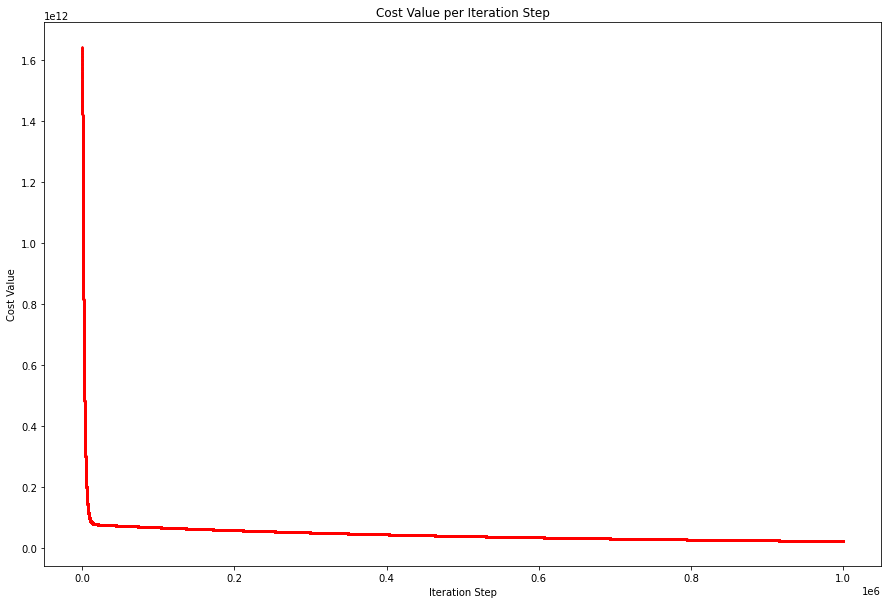

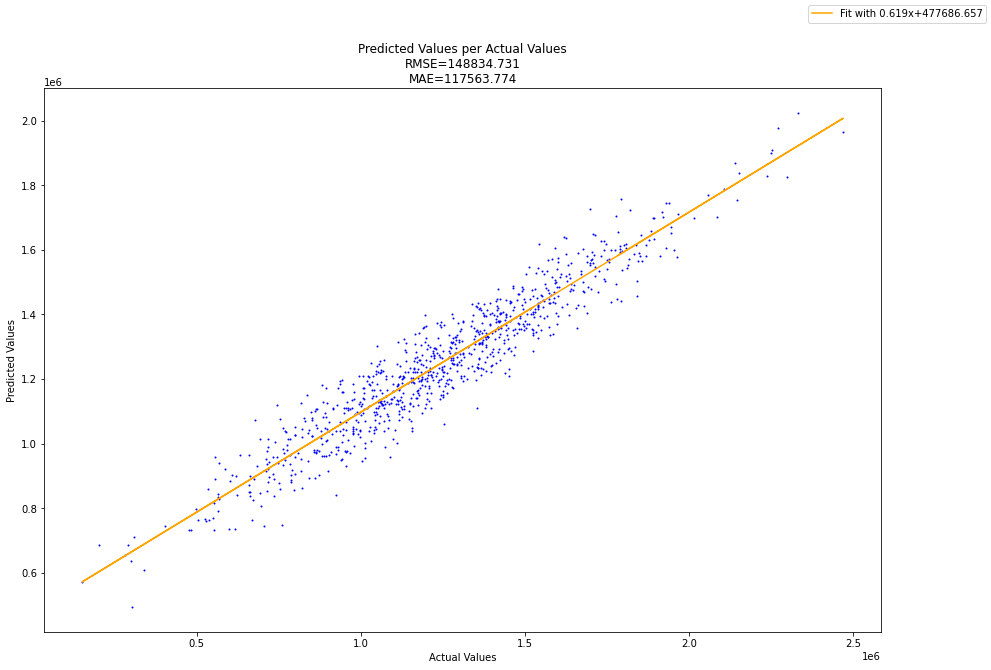

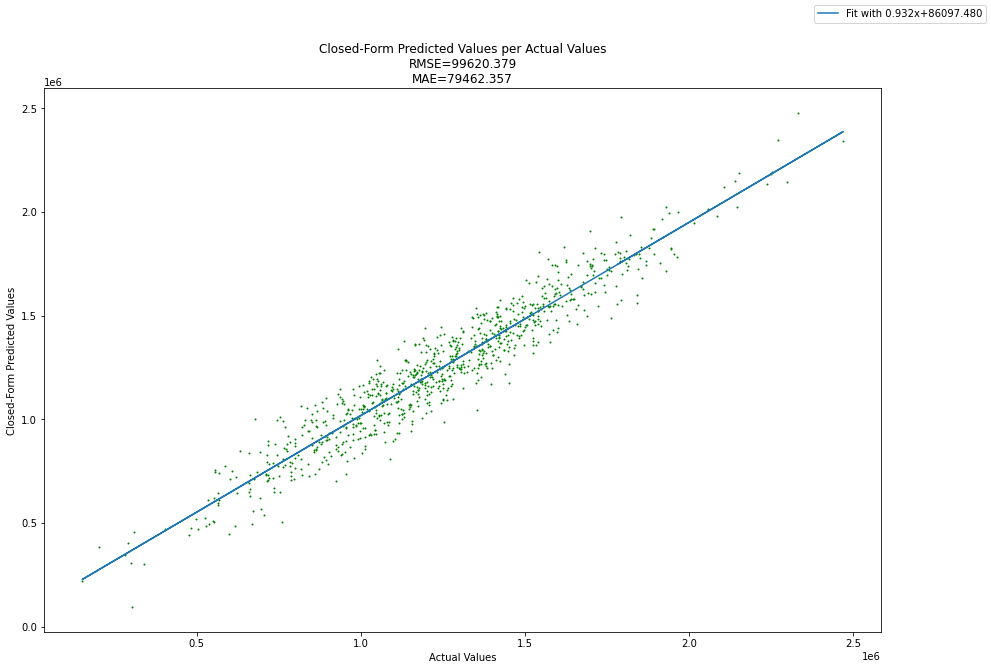

In [48]:
def main(data_csv_path='House_price.csv', test_size=0.2, iteration_cut=10**6,
    random_state=42, saving_directory='', normalized_file_name='normalized',
    train_file_name='train_data', test_file_name='test_data', saving=True,
    plotting=True, learning_rate=10**-4, elasticity=0, normalization_state='linear',
    regularization_param=10**-2, regularization_type='lassp'):
    """
    Valid regularization types: 'no', 'lasso', 'ridge', 'elastic'.
    """
    preparing_data = DataPreparaton(data_csv_path=data_csv_path, test_size=test_size,
                    normalization_state=normalization_state, normalized_file_name=normalized_file_name,
                    train_file_name=train_file_name, test_file_name=test_file_name, random_state=random_state, 
                    saving=saving, saving_directory=saving_directory)
    train_data, test_data = preparing_data.split_data(using_normalized_data=True)
    target_name = preparing_data.target_name
    feature_names = preparing_data.feature_names
    preparing_data.summary()
    linear_model = LinearRegression(train_csv_path='train_data.csv', test_csv_path='test_data.csv',
    target_name=target_name, feature_names=feature_names, iteration_cut=iteration_cut,
    saving=saving, plotting=plotting, learning_rate=learning_rate, regularization_param=regularization_param,
    regularization_type=regularization_type, elasticity=elasticity)
    linear_model.fit()
    linear_model.closed_form()

    preparing_data = DataPreparaton(data_csv_path=data_csv_path, test_size=test_size,
                normalization_state=normalization_state, normalized_file_name=normalized_file_name,
                train_file_name=train_file_name, test_file_name=test_file_name, random_state=random_state, 
                saving=saving, saving_directory=saving_directory)


main()    